In [1]:
from music21 import note, stream
import utils, importlib
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

class MidiLSTM(nn.Module):
    def __init__(self, n_vocab, embed_size, lstm_size):
        super(MidiLSTM, self).__init__()
        self.lstm_size = lstm_size
        self.embed = nn.Embedding(n_vocab, embed_size)
        self.lstm = nn.LSTM(embed_size,
                            lstm_size,
                            batch_first=True)
        self.linear = nn.Linear(lstm_size, n_vocab)

    def forward(self, x, hc):
        embed = self.embed(x)
        output, state = self.lstm(embed, hc)
        result = torch.flatten(self.linear(output), start_dim=0, end_dim=1)
        return result, state

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))

In [2]:
importlib.reload(utils)
batch_size = 16
seq_len = 16
embed_size = 64
lstm_size = 64
json_dir = 'beethoven_jsons'

data, song_starts, note_counts = utils.get_data_from_files(json_dir, batch_size, seq_len)

batches = []
num_batches= np.prod(data['train_in'].shape)
for i in range(0, num_batches * seq_len, seq_len):
    batches.append((data['train_in'][:, i:i+seq_len], data['train_out'][:, i:i+seq_len]))


def train(model, nepoch):
    global_losses = []
    for epoch in range(nepoch):
        hc_0 = model.zero_state(batch_size)
        losses = []
        for inputs, ideal in batches:
            if len(inputs[0]) == seq_len:
                optimizer.zero_grad()
                outputs, hc_0 = model(inputs, (hc_0[0].detach(), hc_0[1].detach()))
                loss = criterion(outputs, torch.flatten(ideal))
                losses.append(loss.detach().numpy())
                loss.backward()
                optimizer.step()
                losses.append(loss.mean().item())
        if not epoch%100:
            print("Loss(%d):"%epoch, np.mean(losses))
        global_losses.append(np.mean(losses))
    return global_losses

388
65072


In [3]:
model = MidiLSTM(data['n_vocab'], embed_size, lstm_size)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0005)
losses = train(model, 3001)

Loss(0): 5.883960247039795
Loss(100): 1.7972690077388989
Loss(200): 1.1663234981836057
Loss(300): 0.8183694189670039
Loss(400): 0.5979495638725805
Loss(500): 0.43685748880984737
Loss(600): 0.34606941131984487
Loss(700): 0.25885118631755605
Loss(800): 0.1902259988527672
Loss(900): 0.15609048832865322
Loss(1000): 0.13188653877552817
Loss(1100): 0.10068848919050366
Loss(1200): 0.0827140203293632
Loss(1300): 0.1670017975802515
Loss(1400): 0.08480429262215015
Loss(1500): 0.19476771456938163
Loss(1600): 0.06441100628352632
Loss(1700): 0.04709820383611847
Loss(1800): 0.04874642573150934
Loss(1900): 0.3883083141317554
Loss(2000): 0.07668926274659586
Loss(2100): 0.05592959374189377
Loss(2200): 0.03034903437775724
Loss(2300): 0.1414147453273044
Loss(2400): 0.03982611080887271
Loss(2500): 0.026402999299998377
Loss(2600): 0.02630831454606617
Loss(2700): 0.025340698367240382
Loss(2800): 0.024667644855000226
Loss(2900): 0.025770034951468308
Loss(3000): 0.02287324581879611


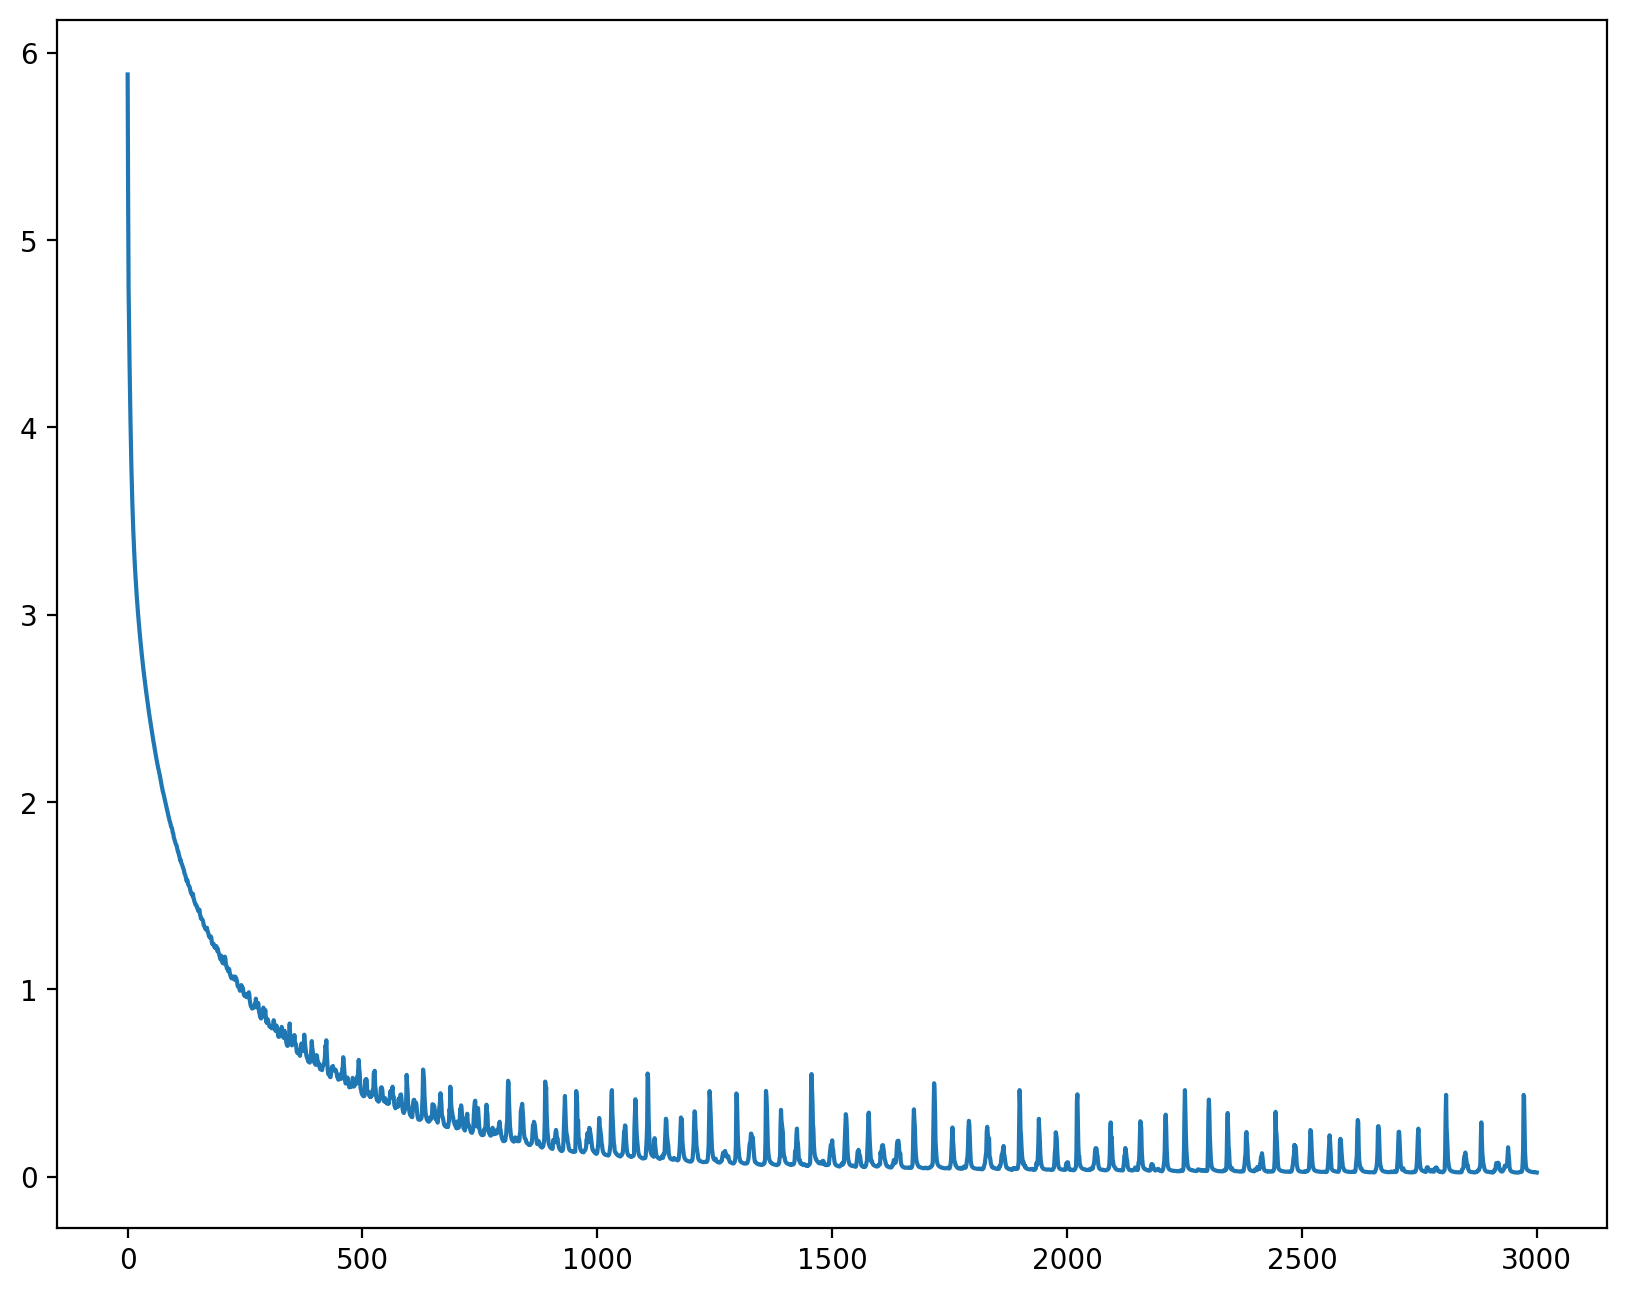

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=100)
plt.plot(losses)

In [6]:
def test(model):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        hn = model.zero_state(1)
        for inputs, ideal in zip(data['test_in'], data['test_out']):
            outputs, hn = model(inputs.view(1, -1), (hn[0], hn[1]))
            predicted = np.argmax(outputs, axis=1) # get predicted class label for each test example.
            #print(predicted[0].detach().item(), " is ", data['int_to_vocab'][predicted[0].detach().item()])
            total += len(predicted)
            correct += np.sum([1 if predicted[i] == ideal[i] else 0 for i in range(len(predicted))])
            true.append(ideal)
            pred.append(predicted)
            
    acc = (100 * correct / total)
    print('Test accuracy: %0.3f' % acc)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return true, pred

In [7]:
true, pred = test(model)

Test accuracy: 98.032


13056


<Figure size 2240x1600 with 0 Axes>

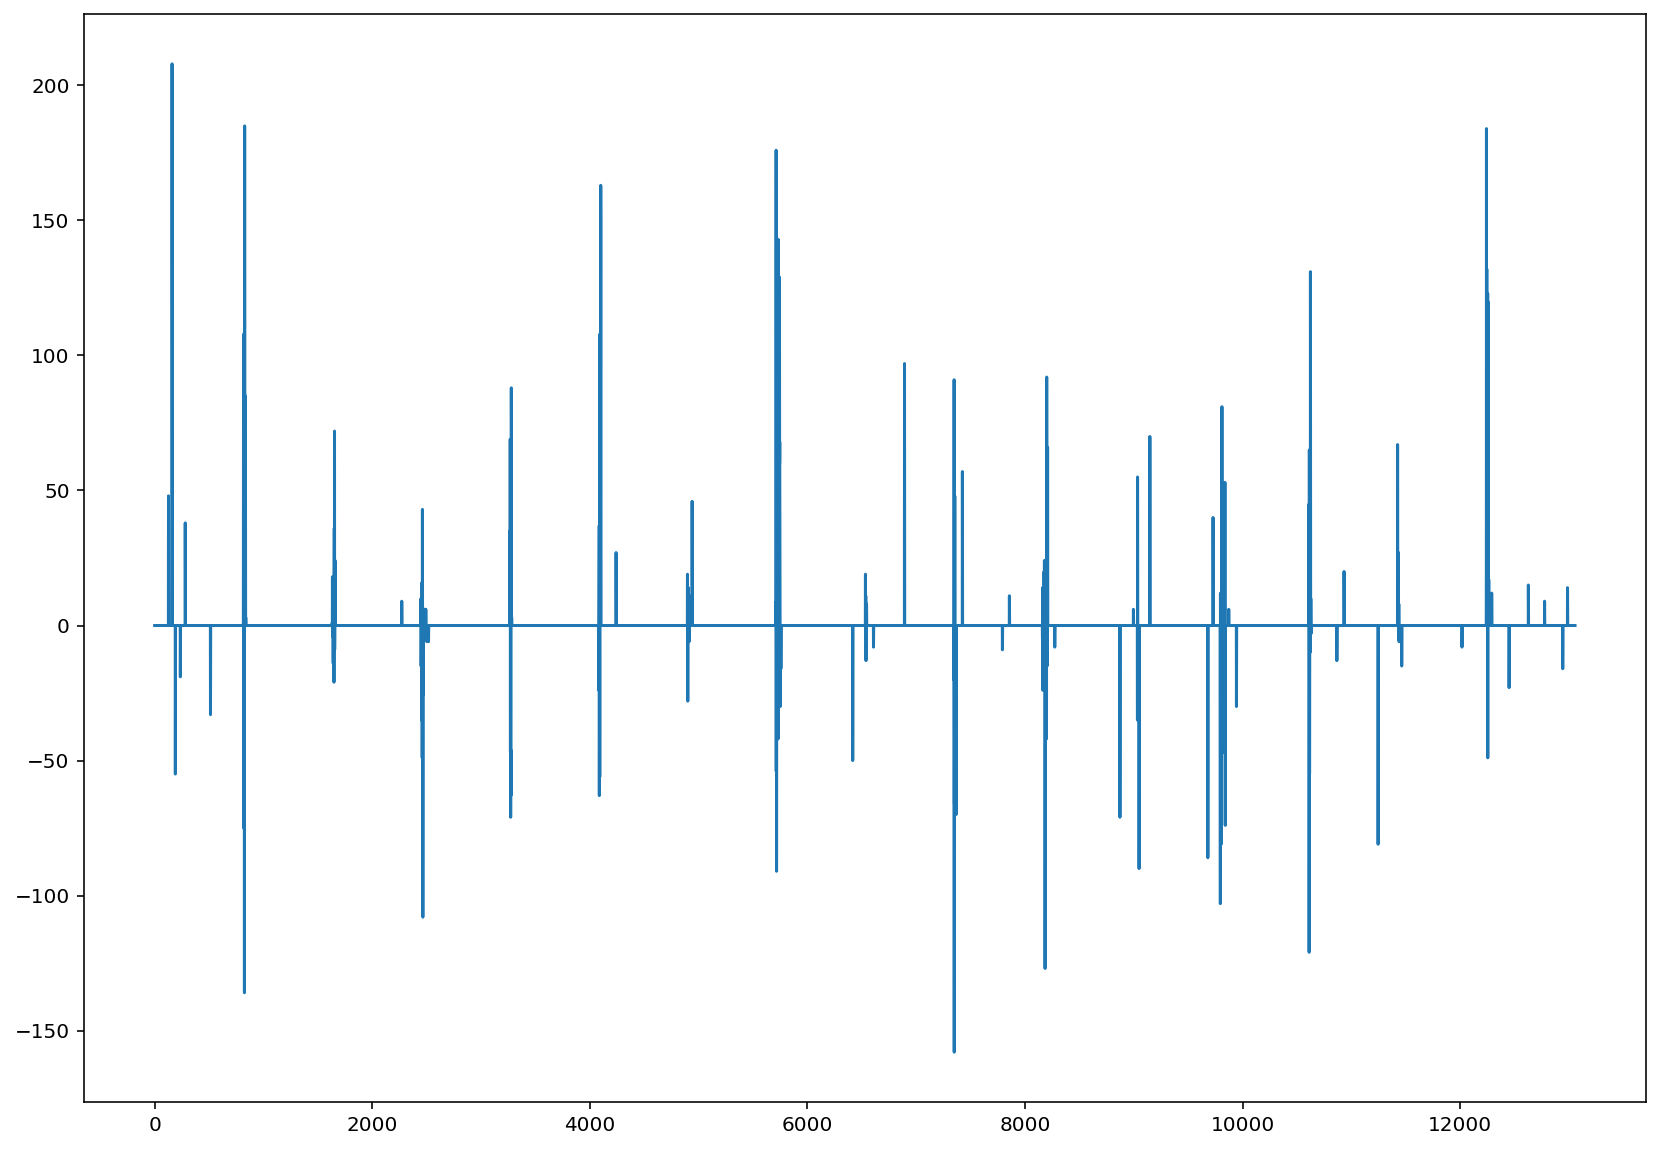

In [8]:
figure(figsize=(14, 10), dpi=160)
diff = np.subtract(true, pred)
print(len(diff))

fig, ax = plt.subplots(figsize=(14, 10))
plt.plot(diff)
plt.show()

In [9]:
def norm(x):
        x = x.to(torch.float64)
        normfn = np.linalg.norm(x)
        result = x/normfn
        if sum(result) == 0. or sum(x) == 0.:
            print(normfn)
            print(x)
            print(result)
            
        return result
    
def expon(x):
    result = torch.tensor([np.exp(y) for y in x])
    return result

def multi(x):
    return torch.multinomial(x, num_samples=1)

def zero(x, cutoff):
    idx = np.argsort(x)
    for i in range(len(x)):
        index = idx[i]
        if i < len(x) - cutoff:
            x[index] = 0
    return x

def get_func(name):               
    if name == 'argmax':
        return np.argmax
    if name == 'multinomial':
        return lambda x: multi(expon(x))
    if name == 'topk':
        cutoff = 10
        return lambda x: multi(norm(zero(expon(x), cutoff)))

In [10]:
def convert_song_to_words(song):
    return [data['int_to_vocab'][x] for x in song]  

In [11]:
def get_length_list(words_list):
    words_list = convert_song_to_words(words_list)
    times = {
        'breve' : 8,
        'whole' : 4,
        'half' : 2,
        'quarter': 1,
        'eighth' : .5,
        '16th' : .25,
        'zero' : .5,
        'complex': .5,
        
    }
    
    length_list = []
    total = 0
    for note_word in words_list:
        note_word_parts = note_word.split('_')
        note_duration = times[note_word_parts[2]]
        total += note_duration
        length_list.append(total)
        
    return length_list

In [12]:
def get_input_sequences(percent_train):
    input_sequence_end_times = []

    first_start = 0
    for i in range(0, len(note_counts) - 1, 2):
        first_time = note_counts[i]
        second_time = note_counts[i + 1]
        second_start = first_start + first_time
        
        input_end = int((first_time * percent_train)) + first_start
        first_list = get_length_list(data['inputs'][first_start:input_end])
        second_list = get_length_list(data['inputs'][second_start:second_start + second_time])

        condition = False
        while not condition:
            end_length = first_list[-1]
            for i in range(len(second_list)):
                length = second_list[i]
                if length >= end_length:
                    input_sequence_end_times.append(len(first_list))
                    input_sequence_end_times.append(i)
                    condition = True
                    break
            if not condition:
                first_list.pop()
        
        first_start = second_start + second_time
        
    return input_sequence_end_times

def loss_time_test(sampling_method, max_run=60, percent_train=.5):
    end_times = get_input_sequences(percent_train)
    func = get_func(sampling_method)
    
    input_sequence = torch.tensor(data['inputs'])
    output_expected = torch.tensor(data['ideal'])
    current_time = 0
    song_losses = []
    whole_songs = []
    orig_songs = []
    test_sections = []
    with torch.no_grad():
        for i in range(len(note_counts)):
            time_step = note_counts[i]
            test_start = int(time_step * percent_train)
            hn = model.zero_state(1)
            run_time = min(current_time + time_step, current_time + test_start + max_run)
            train_inputs = input_sequence[current_time:current_time + end_times[i]]
            test_outputs = output_expected[current_time + test_start:run_time]
            orig_songs.append(train_inputs[-10:].tolist() + test_outputs.tolist())
            
            output, hn = model(train_inputs.view(1, -1), hn)
            next_output_dist = output[-1]
            all_losses = []
            current_song = train_inputs[-10:].tolist()
            test_section = []
            for i in range(len(test_outputs)):
                loss = criterion(next_output_dist.view(1, -1), test_outputs[i].view(1))
                all_losses.append(loss.detach().item())
                prediction = func(next_output_dist)
                current_song.append(prediction.detach().item())
                test_section.append(prediction.detach().item())
                inp = torch.tensor([[prediction]], requires_grad=False, dtype=torch.int64)
                output, hn = model(inp, hn)
                next_output_dist = output[0]
            
            whole_songs.append(current_song)
            song_losses.append(all_losses)
            test_sections.append(test_section)
            current_time += time_step
            
    return song_losses, whole_songs, orig_songs, test_sections  
        
        

In [16]:
argmax_losses, arg_songs, _, arg_test = loss_time_test('argmax')
multinomial_losses, mult_songs, _, mult_test = loss_time_test('multinomial')
topk_losses, topk_songs, orig_songs, topk_test = loss_time_test('topk')

In [17]:
def plot_avg_losses(losses):
    largest_len = np.max([len(x) for x in losses])
    sum_plot = np.zeros(largest_len)
    counts = np.zeros(largest_len)
    for i in range(len(losses)):
        for j in range(len(losses[i])):
            sum_plot[j] += losses[i][j]
            counts[j] += 1
    
    avg_plot = [x/y for x, y in zip(sum_plot, counts)]
    
    plt.plot(avg_plot)
    plt.show()

Test: argmax


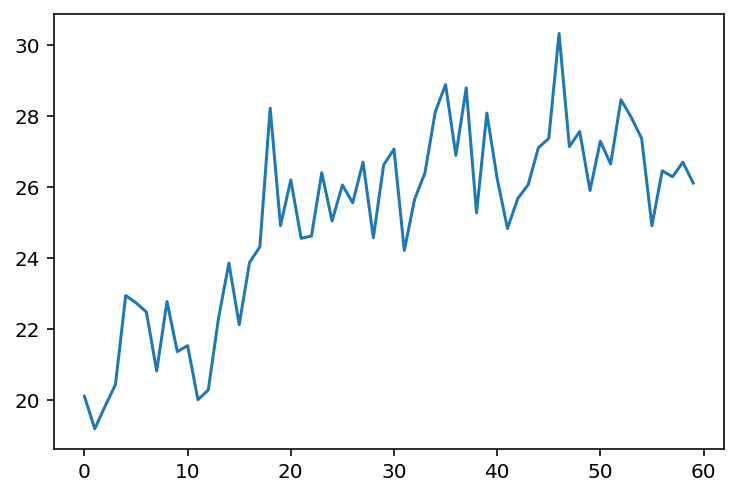

Test: multinomial


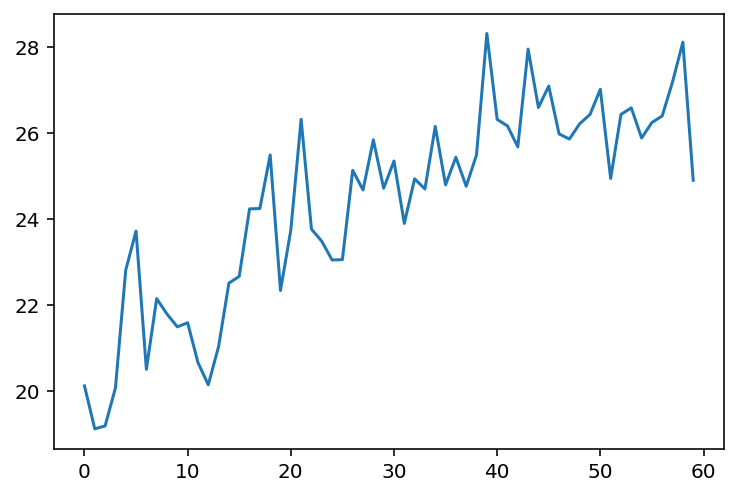

Test: topk


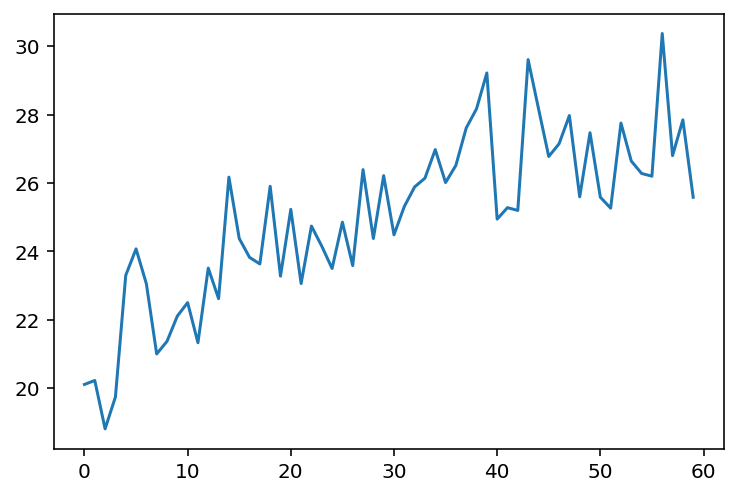

In [18]:
print('Test: argmax')
plot_avg_losses(argmax_losses)
print('Test: multinomial')
plot_avg_losses(multinomial_losses)
print('Test: topk')
plot_avg_losses(topk_losses)

In [346]:
importlib.reload(utils)

full_song_decodes = {}
lengths = []
for song_list, title in zip((arg_songs, mult_songs, topk_songs, orig_songs), ('arg', 'mult', 'topk', 'orig')):
    for i in range(len(song_list)):
        name = '{}_{}.mid'.format(title, data['song_names'][i])
        song = convert_song_to_words(song_list[i])
        song_stream, length = utils.decode_words_to_notes(song)
        lengths.append(length)
        full_song_decodes[name] = song_stream

In [347]:
import os
#importlib.reload(utils)

def write_raw_output(songs, midi_dir='output_midis'):

    length = len(data['instruments'])
    try:
        os.mkdir(midi_dir)
    except:
        pass
    
    song_key_list = list(songs.keys())
    for i in range(0, len(songs.keys()) - 1, 2):
        group = [songs[song_key_list[i]], songs[song_key_list[i+1]]]
        nums = [i, i + 1]
        
        longer_song = np.argmax((lengths[i], lengths[i + 1]), axis=0)
        diff = abs(lengths[i] - lengths[i + 1])
        long_len = lengths[nums[longer_song]]
        short_len = lengths[nums[(longer_song + 1)%2]]
        while long_len > short_len:
            note = group[longer_song].pop(-1)
            long_len -= note.duration.quarterLength 
    
    for key in songs.keys():
        song_stream = songs[key]
        
        midi_file = "{}/{}".format(midi_dir, key)
        
        song_stream.write('midi', fp=midi_file)
        print('wrote to', midi_file)



In [348]:
write_raw_output(full_song_decodes)

wrote to output_midis/arg_appass_1-piano_left.mid
wrote to output_midis/arg_appass_1-piano_right.mid
wrote to output_midis/arg_appass_2-piano_left.mid
wrote to output_midis/arg_appass_2-piano_right.mid
wrote to output_midis/arg_appass_3-piano_left.mid
wrote to output_midis/arg_appass_3-piano_right.mid
wrote to output_midis/arg_beethoven_hammerklavier_1-piano_left.mid
wrote to output_midis/arg_beethoven_hammerklavier_1-piano_right.mid
wrote to output_midis/arg_beethoven_hammerklavier_2-piano_left.mid
wrote to output_midis/arg_beethoven_hammerklavier_2-piano_right.mid
wrote to output_midis/arg_beethoven_hammerklavier_3-piano_left.mid
wrote to output_midis/arg_beethoven_hammerklavier_3-piano_right.mid
wrote to output_midis/arg_beethoven_hammerklavier_4-piano_left.mid
wrote to output_midis/arg_beethoven_hammerklavier_4-piano_right.mid
wrote to output_midis/arg_beethoven_les_adieux_1-piano_left.mid
wrote to output_midis/arg_beethoven_les_adieux_1-piano_right.mid
wrote to output_midis/arg_be

In [349]:
def get_midi_file_names(midi_dir):
    files = utils.get_files(midi_dir)
    new_file_names = []
    for file_name in files:
        tmp = file_name.split('/')[1].split('-')[0]
        new_file_names.append(tmp)
    return files, new_file_names

In [350]:
from mido import MidiFile
import os
import utils
midi_dir = 'output_midis'
to_dir='final_midis'


def combine_midis(midi_dir='output_midis', to_dir='final_midis'):
    try:
        os.mkdir(to_dir)
    except:
        pass
    
    files, new_file_names = get_midi_file_names(midi_dir)

    for i in range(0, len(files) - 1, 2):
        file_path = "{}/{}.mid".format(to_dir, new_file_names[i])
        mid1 = MidiFile(files[i], clip=True)
        mid2 = MidiFile(files[i + 1], clip=True)
        mid1.tracks.append(mid2.tracks[0])
        mid1.save(file_path)
        print('wrote to', file_path)
        

In [351]:
combine_midis()

wrote to final_midis/arg_appass_1.mid
wrote to final_midis/arg_appass_2.mid
wrote to final_midis/arg_appass_3.mid
wrote to final_midis/arg_beethoven_hammerklavier_1.mid
wrote to final_midis/arg_beethoven_hammerklavier_2.mid
wrote to final_midis/arg_beethoven_hammerklavier_3.mid
wrote to final_midis/arg_beethoven_hammerklavier_4.mid
wrote to final_midis/arg_beethoven_les_adieux_1.mid
wrote to final_midis/arg_beethoven_les_adieux_2.mid
wrote to final_midis/arg_beethoven_les_adieux_3.mid
wrote to final_midis/arg_beethoven_opus10_1.mid
wrote to final_midis/arg_beethoven_opus10_2.mid
wrote to final_midis/arg_beethoven_opus10_3.mid
wrote to final_midis/arg_beethoven_opus22_1.mid
wrote to final_midis/arg_beethoven_opus22_2.mid
wrote to final_midis/arg_beethoven_opus22_3.mid
wrote to final_midis/arg_beethoven_opus22_4.mid
wrote to final_midis/arg_beethoven_opus90_1.mid
wrote to final_midis/arg_beethoven_opus90_2.mid
wrote to final_midis/arg_elise.mid
wrote to final_midis/arg_mond_1.mid
wrote t